In [59]:
import pandas as pd
import numpy as np
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson
import datetime

## Preprocessing BL

In [60]:
path_bundesliga = r"preprocessed_dataframe_with_elo_1.csv"
match_data_all_bundesliga = pd.read_csv(path_bundesliga, delimiter=",")
match_data_all_bundesliga.tail()
# match_data_unfiltered.info()
pd.to_datetime('30.06.2021')

Timestamp('2021-06-30 00:00:00')

In [61]:
# convert string date to pandas datetime
match_data_all_bundesliga['Date'] = pd.to_datetime(match_data_all_bundesliga['Date'], dayfirst=True)
match_data_all_bundesliga = match_data_all_bundesliga.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_all_bundesliga.tail(n=5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242
4895,2022-05-14,Wolfsburg,Bayern Munich,2.0,2.0,D,1.0,2.0,A,10.0,...,1.994849,-1.248584,2.255671,-1.869960,1.949939,-0.849493,2.258790,-1.790906,825.333792,1118.372385


In [62]:
match_data_all_bundesliga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4896 non-null   datetime64[ns]
 1   HomeTeam       4896 non-null   object        
 2   AwayTeam       4896 non-null   object        
 3   FTHG           4896 non-null   float64       
 4   FTAG           4896 non-null   float64       
 5   FTR            4896 non-null   object        
 6   HTHG           4896 non-null   float64       
 7   HTAG           4896 non-null   float64       
 8   HTR            4896 non-null   object        
 9   HS             4896 non-null   float64       
 10  AS             4896 non-null   float64       
 11  HST            4896 non-null   float64       
 12  AST            4896 non-null   float64       
 13  HF             4896 non-null   float64       
 14  AF             4896 non-null   float64       
 15  HC             4896 n

In [63]:
df_bl_test_whole_saison = match_data_all_bundesliga[match_data_all_bundesliga['Date'] > pd.to_datetime('2021-06-30')]
df_bl_test_season_partly = match_data_all_bundesliga[match_data_all_bundesliga['Date'] > pd.to_datetime('2021-11-30')]
match_data_bl_past_5_years = match_data_all_bundesliga[(match_data_all_bundesliga.Date < pd.to_datetime('2021-11-30'))&(match_data_all_bundesliga.Date > pd.to_datetime('2015-06-30'))]
match_data_bl_test = match_data_all_bundesliga[(match_data_all_bundesliga.Date < pd.to_datetime('2021-06-30'))]
df_bl_test_season_partly

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
4707,2021-12-03,Union Berlin,RB Leipzig,2.0,1.0,H,1.0,1.0,D,14.0,...,1.785175,-1.363506,1.125889,-2.126520,1.688174,-1.636435,1.274124,-2.159467,661.939715,920.688372
4708,2021-12-04,Augsburg,Bochum,2.0,3.0,A,0.0,3.0,A,16.0,...,1.791680,-2.012590,2.072962,-1.301765,1.434920,-1.083995,1.319257,-0.841161,761.156723,277.929332
4709,2021-12-04,Bielefeld,FC Koln,1.0,1.0,D,0.0,1.0,A,18.0,...,0.815676,-0.982104,2.028400,-1.175795,0.753963,-1.299739,2.641861,-1.244407,303.326388,730.744921
4710,2021-12-04,Hoffenheim,Ein Frankfurt,3.0,2.0,H,2.0,1.0,H,8.0,...,3.571427,-1.832360,1.878782,-1.433270,3.435787,-1.686281,1.772523,-0.607517,879.255093,872.656773
4711,2021-12-04,Leverkusen,Greuther Furth,7.0,1.0,H,3.0,1.0,H,13.0,...,4.063729,-0.899791,1.455713,-6.090472,1.893467,-0.981485,1.709099,-4.957500,876.743973,-0.551284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,2022-05-14,Mainz,Ein Frankfurt,2.0,2.0,D,1.0,2.0,A,13.0,...,2.001489,-1.884149,1.172358,-1.581157,1.868412,-1.545160,0.652603,-1.330148,849.372072,844.265646
4892,2022-05-14,M'gladbach,Hoffenheim,5.0,1.0,H,3.0,1.0,H,19.0,...,3.347095,-1.133621,1.647127,-4.249006,2.048918,-1.426219,2.062127,-3.467829,877.665071,855.590835
4893,2022-05-14,Stuttgart,FC Koln,2.0,1.0,H,1.0,0.0,H,24.0,...,1.491069,-1.100222,1.535998,-1.369941,0.963734,-1.335884,1.877641,-0.890119,734.655957,762.003692
4894,2022-05-14,Union Berlin,Bochum,3.0,2.0,H,2.0,0.0,H,17.0,...,2.870488,-1.234870,1.944127,-2.321089,2.570349,-0.727307,1.757577,-1.887840,746.240131,389.650242


## Preprocessing PL

In [64]:
# read the csv file
path = r"history.csv"
# path = "preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path)

In [65]:
match_data_unfiltered = match_data_unfiltered[match_data_unfiltered['Season'].str.contains('201')]
match_data_unfiltered

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
6624,E0,14/08/10,Aston Villa,West Ham,3,0,H,2.0,0.0,H,2010-11
6625,E0,14/08/10,Blackburn,Everton,1,0,H,1.0,0.0,H,2010-11
6626,E0,14/08/10,Bolton,Fulham,0,0,D,0.0,0.0,D,2010-11
6627,E0,14/08/10,Chelsea,West Brom,6,0,H,2.0,0.0,H,2010-11
6628,E0,14/08/10,Sunderland,Birmingham,2,2,D,1.0,0.0,H,2010-11
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [66]:
# split train test data
# df_train = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 != 0]  # Excludes every 3rd row starting from 0
# df_test = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 == 0]  # Selects every 3rd row starting from 0
# match_data_unfiltered = df_train
# df_test = match_data_unfiltered[match_data_unfiltered['Season']=='2017-18']
# match_data_unfiltered = match_data_unfiltered[(match_data_unfiltered['Season'].str.contains('201'))&(match_data_unfiltered['Season']!='2017-18')]
df_test = match_data_unfiltered.iloc[-100:, :]
match_data_unfiltered = match_data_unfiltered.iloc[:-100,:]
df_test


,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [67]:
df_test

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9564,E0,3/3/2018,Burnley,Everton,2,1,H,0.0,1.0,A,2017-18
9565,E0,3/3/2018,Leicester,Bournemouth,1,1,D,0.0,1.0,A,2017-18
9566,E0,3/3/2018,Liverpool,Newcastle,2,0,H,1.0,0.0,H,2017-18
9567,E0,3/3/2018,Southampton,Stoke,0,0,D,0.0,0.0,D,2017-18
9568,E0,3/3/2018,Swansea,West Ham,4,1,H,2.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


## Data Knowledge

In [68]:
# for predicting bl with mathematical method: 
# else just comment the line above
match_data_unfiltered = match_data_bl_past_5_years
df_test = df_bl_test_season_partly

In [69]:
# winning_team
winning_team = match_data_unfiltered['FTR'].value_counts()
print(f"Gewinnchancen \nHome Team: {winning_team['H']/winning_team.sum()}")
print(f"Away Team: {winning_team['A']/winning_team.sum()}")
print(f"Draw: {winning_team['D']/winning_team.sum()}")

Gewinnchancen 
Home Team: 0.4470046082949309
Away Team: 0.30824372759856633
Draw: 0.24475166410650281


## Modeltraining 

In [70]:
# make FTR column to continous variable
# def convert_ftr(result: str):
#     if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
#     else: 
#         return None
# match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [71]:
# [match_data_unfiltered['Season'].str.contains('201')]

max prob mit einem Testdatensatz von 50: 58% 
komplette halbe Saison: 64%

In [72]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HomeElo,AwayElo,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,HomeEloOld,AwayEloOld
FTHG,1.000000,-0.149165,0.680891,-0.093923,0.322225,-0.154628,0.617652,-0.148509,-0.139993,-0.106968,0.062671,-0.100769,-0.143620,-0.014436,-0.078391,0.036154,0.293788,-0.139029,0.823713,0.175459,-0.146687,-0.765225,0.244718,0.122994,-0.094917,-0.078520,0.256700,-0.103691
FTAG,-0.149165,1.000000,-0.090836,0.686872,-0.098642,0.324336,-0.127655,0.586067,-0.001748,-0.056783,-0.054048,0.074013,0.098699,-0.036830,0.096155,-0.072304,-0.108024,0.255779,-0.156464,-0.763187,0.717744,0.168602,-0.112230,-0.054734,0.181721,0.107371,-0.075938,0.222551
HTHG,0.680891,-0.090836,1.000000,-0.093062,0.147177,-0.062675,0.385116,-0.068201,-0.058521,-0.060535,-0.001238,-0.011171,-0.114437,-0.000345,-0.006417,-0.008469,0.191529,-0.070097,0.574219,0.115747,-0.087166,-0.511032,0.187660,0.088679,-0.056106,-0.040665,0.166613,-0.046521
HTAG,-0.093923,0.686872,-0.093062,1.000000,0.001107,0.170807,-0.036216,0.389610,0.009250,-0.018910,0.016931,0.002324,0.075465,-0.039068,0.038371,-0.012922,-0.060778,0.209996,-0.086388,-0.514740,0.524944,0.128587,-0.055395,-0.033473,0.169825,0.100654,-0.039489,0.187448
HS,0.322225,-0.098642,0.147177,0.001107,1.000000,-0.330308,0.690849,-0.212216,-0.157752,-0.005637,0.537223,-0.264542,-0.111749,0.030834,-0.118447,0.105836,0.240467,-0.190523,0.335333,0.109470,-0.187984,-0.294749,0.217753,0.102973,-0.194282,-0.119742,0.235348,-0.186280
AS,-0.154628,0.324336,-0.062675,0.170807,-0.330308,1.000000,-0.236367,0.685129,0.037253,-0.082398,-0.263615,0.492244,0.120052,-0.028366,0.106396,-0.111435,-0.159508,0.221943,-0.206355,-0.312250,0.322648,0.166679,-0.193026,-0.155523,0.200461,0.109088,-0.152882,0.215047
HST,0.617652,-0.127655,0.385116,-0.036216,0.690849,-0.236367,1.000000,-0.169659,-0.130492,-0.062927,0.338235,-0.186132,-0.127176,0.026927,-0.081730,0.098093,0.276570,-0.166160,0.556985,0.149088,-0.157720,-0.491328,0.242776,0.114959,-0.127959,-0.090284,0.257529,-0.148538
AST,-0.148509,0.586067,-0.068201,0.389610,-0.212216,0.685129,-0.169659,1.000000,0.001720,-0.079316,-0.150601,0.321425,0.119466,-0.052177,0.072668,-0.086298,-0.100519,0.250553,-0.163211,-0.489799,0.463808,0.173574,-0.126677,-0.116944,0.176347,0.117889,-0.083265,0.232126
HF,-0.139993,-0.001748,-0.058521,0.009250,-0.157752,0.037253,-0.130492,0.001720,1.000000,0.237834,-0.133154,0.011844,0.375196,0.116638,0.075292,0.030560,-0.293443,-0.156096,-0.232504,-0.060371,-0.051622,0.085143,-0.237621,-0.082867,-0.063637,0.004320,-0.289168,-0.156018
AF,-0.106968,-0.056783,-0.060535,-0.018910,-0.005637,-0.082398,-0.062927,-0.079316,0.237834,1.000000,-0.040968,-0.031207,0.094082,0.343478,0.041790,0.036192,-0.194146,-0.261107,-0.132433,-0.006314,-0.141175,0.052838,-0.097151,-0.042343,-0.148548,-0.027370,-0.188882,-0.262165


In [73]:
history_pair_h = match_data_unfiltered.groupby(['HomeTeam', 'AwayTeam'])
ave_home_scored = history_pair_h['FTHG'].mean()
history_pair_a = match_data_unfiltered.groupby(['AwayTeam', 'HomeTeam'])
ave_away_scored = history_pair_a['FTAG'].mean()

ave_away_scored.keys()
ave_away_scored

AwayTeam   HomeTeam     
Augsburg   Bayern Munich    0.666667
           Bielefeld        1.000000
           Darmstadt        2.000000
           Dortmund         1.285714
           Ein Frankfurt    1.000000
                              ...   
Wolfsburg  RB Leipzig       1.000000
           Schalke 04       1.500000
           Stuttgart        1.000000
           Union Berlin     1.333333
           Werder Bremen    1.166667
Name: FTAG, Length: 575, dtype: float64

In [74]:
# import numpy as np
home_goals_av = np.ones(100)
away_goals_av = np.ones(100)

for i in range(len(match_data_unfiltered)-1000):
    counter = i + 1000
    home_team = match_data_unfiltered['HomeTeam'].iloc[counter]
    away_team = match_data_unfiltered['AwayTeam'].iloc[counter]
    # print(match_data_unfiltered.iloc[counter])
    # print(home_team, away_team)
    # home_goals_av.append(av)

## Verbesserungen:
- nur direkten Vergleich nehmen, wenn Mannschaften mind. 5x gegeneinander gespielt haben
- immer alle Werte miteinbeziehen --> Testen ob besser
- Testen der Features mit ML
- Naive Bayes oder anderen ML (Poisson Regression Model) verwenden und Possion Verteilung verwenden

In [75]:
home_test = ave_home_scored.index[0][0]
away_test = ave_home_scored.index[0][1]
print(home_test)
t_ave_h_scored = ave_home_scored.loc[home_test].mean()
t_ave_h_scored

Augsburg


1.403373015873016

In [76]:
# predict with the possion distribution which team will win 
def get_score(home, away, number_of_simulations):
    result = []
    try:
        ave_h_scored = ave_home_scored.loc[home, away]#, ave_away_scored.loc(away)}
        ave_a_scored = ave_away_scored.loc[away, home]
        # if the teams already played against each other it uses the last games goal distribution 
        # to predict the result for the pending game
        for i in range(number_of_simulations):
            h_scored = poisson.rvs(1, ave_h_scored)
            a_scored = poisson.rvs(1, ave_a_scored)
            result.append([h_scored, a_scored])
        return result

    except:
        # try:
        t_ave_h_scored = ave_home_scored.loc[home].mean()
        t_ave_h_conceded = ave_away_scored.loc[:, home].mean()
        t_ave_a_scored = ave_away_scored.loc[away].mean()
        t_ave_a_conceded = ave_home_scored.loc[:, away].mean()
        # except:
        #     return []


        for i in range(number_of_simulations):
            h_scored = poisson.rvs(1, (t_ave_h_scored+t_ave_a_conceded)/2)
            a_scored = poisson.rvs(1, (t_ave_a_scored+t_ave_h_conceded)/2)
            result.append([h_scored, a_scored])
        return result

    # return ave_h_scored, ave_a_scored
score_arsenal_wh = get_score(home_test, away_test, 1000)

In [77]:
# result = pd.DataFrame(columns=["Winner"])
alpha = 0.04
number_of_repetitions = 1000

def get_result_for_one_single_match(home_team, away_team):
    result = []
    x = get_score(home_team, away_team, number_of_repetitions)
    for i in x:
        if i[0] > i[1]:
            result.append('H')
        elif i[0] == i[1]:
            result.append('D')
        else:
            result.append('A')
    # if x == []:
    #     return None
    home_win = result.count('H')/len(result)
    away_win = result.count('A')/len(result)
    draw = result.count('D')/len(result)
    print(f"Probability for home win: {home_win}, Away_win: {away_win}, draw: {draw}, Teams: {home_team, away_team}")
    return 'H' if home_win > away_win and home_win > (draw+alpha) else 'A' if away_win > (draw+alpha) else 'D' 

In [78]:
df_test['PredictedResult'] = None
# df_test[]
# df_test = df_test.tail(n=100)
for i in df_test.index:
    home_team = df_test['HomeTeam'][i]
    away_team = df_test['AwayTeam'][i]
    df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)

c:\Users\Phili\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Phili\AppData\Local\Temp/ipykernel_32360/1684315969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)


Probability for home win: 0.133, Away_win: 0.64, draw: 0.227, Teams: ('Union Berlin', 'RB Leipzig')
Probability for home win: 0.669, Away_win: 0.131, draw: 0.2, Teams: ('Augsburg', 'Bochum')
Probability for home win: 0.658, Away_win: 0.127, draw: 0.215, Teams: ('Bielefeld', 'FC Koln')
Probability for home win: 0.141, Away_win: 0.66, draw: 0.199, Teams: ('Hoffenheim', 'Ein Frankfurt')
Probability for home win: 0.91, Away_win: 0.02, draw: 0.07, Teams: ('Leverkusen', 'Greuther Furth')
Probability for home win: 0.323, Away_win: 0.334, draw: 0.343, Teams: ('Mainz', 'Wolfsburg')
Probability for home win: 0.343, Away_win: 0.372, draw: 0.285, Teams: ('Dortmund', 'Bayern Munich')
Probability for home win: 0.66, Away_win: 0.129, draw: 0.211, Teams: ('Stuttgart', 'Hertha')
Probability for home win: 0.665, Away_win: 0.129, draw: 0.206, Teams: ("M'gladbach", 'Freiburg')
Probability for home win: 0.339, Away_win: 0.348, draw: 0.313, Teams: ('FC Koln', 'Augsburg')
Probability for home win: 0.971, Awa

In [79]:
# df_test['True'] = df_test[df_test['FTR']==df_test['PredictedResult']]
# df_test['True'].count_values()

In [80]:
# df_test = df_test.dropna()
len(df_test[df_test['FTR']==df_test['PredictedResult']])/len(df_test)

0.4444444444444444

In [81]:
df_test['FTR'].value_counts()

H    84
A    60
D    45
Name: FTR, dtype: int64

In [82]:
df_test['PredictedResult'].value_counts()

H    107
A     57
D     25
Name: PredictedResult, dtype: int64

# Evaluation:
- Vergleich mit Wettanbierter --> Gewinn?

In [83]:
df_test.to_csv("predicted_season_17-18_PL.csv")

In [84]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld"]]

correlation_matrix_match_data_reduced = match_data_reduced.corr()
correlation_matrix_match_data_reduced.style.background_gradient()

,FTHG,FTAG,HomeEloOld,AwayEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld
FTHG,1.000000,-0.149165,0.256700,-0.103691,0.244718,0.122994,-0.094917,-0.078520
FTAG,-0.149165,1.000000,-0.075938,0.222551,-0.112230,-0.054734,0.181721,0.107371
HomeEloOld,0.256700,-0.075938,1.000000,0.101686,0.474237,0.193947,0.004748,-0.039395
AwayEloOld,-0.103691,0.222551,0.101686,1.000000,0.012240,-0.008782,0.464301,0.211469
HomeAttackOld,0.244718,-0.112230,0.474237,0.012240,1.000000,0.257302,-0.002842,0.002294
HomeDefendOld,0.122994,-0.054734,0.193947,-0.008782,0.257302,1.000000,0.005614,0.018765
AwayAttackOld,-0.094917,0.181721,0.004748,0.464301,-0.002842,0.005614,1.000000,0.260379
AwayDefendOld,-0.078520,0.107371,-0.039395,0.211469,0.002294,0.018765,0.260379,1.000000


In [85]:
X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    "AwayAttackOld", "AwayDefendOld"
]]

# use full time home goals and full time away goals; alternatively also using result directly is possible
y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, y_train = X, y

In [86]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [87]:
# clf.predict(X_test)

In [88]:
# result = clf.score(X_test, y_test)

In [89]:
# result

In [90]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [91]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks
#create model
model = Sequential()

#get number of columns in training data
n_cols_2 = X_train.shape[1]
print(n_cols_2)

#add layers to model
model.add(Dense(10, activation='relu', input_shape=(n_cols_2, )))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
model.compile(metrics=['accuracy'], optimizer='rmsprop', 
              loss='categorical_crossentropy')
# K.set_value(model.optimizer.learning_rate, 0.01)

# early_stopping_monitor = EarlyStopping(patience=3)

es = callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) 


history = model.fit(X_train, y_train,  epochs=30, batch_size = 500, validation_split=0.3) #, callbacks=[early_stopping_monitor]) #callbacks=[es],

6
Epoch 1/30
2/2 [==============================] - 1s 149ms/step - loss: 274.3815 - accuracy: 0.7115 - val_loss: 284.5145 - val_accuracy: 0.6412
Epoch 2/30
2/2 [==============================] - 0s 20ms/step - loss: 242.4127 - accuracy: 0.7115 - val_loss: 261.1350 - val_accuracy: 0.6412
Epoch 3/30
2/2 [==============================] - 0s 20ms/step - loss: 223.8513 - accuracy: 0.7115 - val_loss: 239.6142 - val_accuracy: 0.6412
Epoch 4/30
2/2 [==============================] - 0s 22ms/step - loss: 204.2196 - accuracy: 0.7115 - val_loss: 221.6242 - val_accuracy: 0.6412
Epoch 5/30
2/2 [==============================] - 0s 20ms/step - loss: 188.3296 - accuracy: 0.7082 - val_loss: 205.3795 - val_accuracy: 0.6387
Epoch 6/30
2/2 [==============================] - 0s 22ms/step - loss: 177.1491 - accuracy: 0.7104 - val_loss: 186.9426 - val_accuracy: 0.6336
Epoch 7/30
2/2 [==============================] - 0s 20ms/step - loss: 159.4964 - accuracy: 0.7038 - val_loss: 171.1951 - val_accuracy: 0.6

In [92]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 878us/step - loss: 50.1238 - accuracy: 0.6946


[50.12379455566406, 0.6945736408233643]

In [93]:
test = model.predict(X_test)
winning_team = []
for item in test:
    if abs(item[0]-item[1]) < 0.5:
        winning_team.append(2)
    elif item[0] > item[1]:
        winning_team.append(3)
    else:
        winning_team.append(1)
#   if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
winning_team.count(2)

0

In [94]:
winning_team_test = []
for item in np.array(y_test):
    if item[0] > item[1]:
        winning_team_test.append(3)
    elif item[0] == item[1]:
        winning_team_test.append(2)
    else:
        winning_team_test.append(1)
len(winning_team)

645

In [95]:
y_test
test

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99999881e-01, 1.12906676e-07],
       ...,
       [1.00000000e+00, 2.69390874e-08],
       [1.00000000e+00, 4.18016503e-16],
       [1.00000000e+00, 1.04591689e-10]], dtype=float32)

In [96]:
counter = 0
for i in range(len(winning_team)):
    if winning_team[i] == winning_team_test[i]:
        counter += 1
counter/len(winning_team)

0.43410852713178294

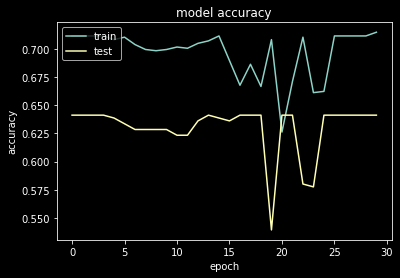

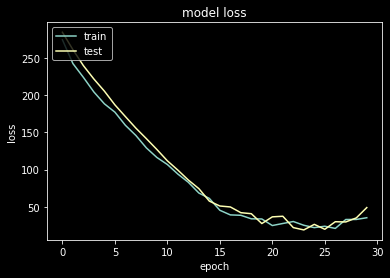

In [97]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()